In [13]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets
from d2l import torch as d2l
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from torchvision import transforms

# 6. 卷积神经网络

## 卷积

[多层感知机](./chapter4.ipynb)是一个由全连接层构成的网络，一个全连接层在数学中表示一个函数

$$f: \mathbb{R}^{d_{in}} \rightarrow \mathbb{R}^{d_{out}}$$

其包含一个权重矩阵$\mathbf{W}$（$\mathbb{R}^{d_{in}\times d_{out}}$）和一个偏置向量$\mathbf{b}$（$\mathbb{R}^{d_{out}}$）

其输出$\mathbf{h}$为

$$\mathbf{h}=\mathbf{x^\top}\mathbf{W}+\mathbf{b}\quad, h_i=\sum_{i=1}^{d_{in}}x_iw_i+b_i$$

对于一张大小$h \times w$的图像，我们之前的做法是将图像展开为包含$h \times w$个元素的向量作为全连接层的输入，这会丢失空间信息。比如在空间中两个像素$\mathbf{X}_{i, j}$和$\mathbf{X}_{i+1, j}$是相邻的，但是展开为向量后，两者不再是相邻的了。

$$\mathbf{X}_{\mathbb{R}^{h \times w}} \rightarrow \mathbf{X'}_{\mathbb{R}^{hw}}\quad \mathbf{X'}_i=\mathbf{X}_{{\lfloor{i/w}\rfloor}, {i\bmod w}}$$ 

其次是全连接层参数过多的问题，对于大小为$h \times w$的图像，共有

$$h \times w \times d_{out} + d_{out}$$

个参数。

卷积可以避免上述全连接层的问题，其输入是一个$h \times w$的矩阵，输出是$h' \times w'$的矩阵

$$\begin{aligned}
    \mathbf{H}_{i, j} 
        &= u + \sum_{a=-\Delta}^{\Delta}\sum_{b=-\Delta}^{\Delta}\mathbf{V_{a, b}}\mathbf{X}_{i+a,j+b}
\end{aligned}$$

其中$\mathbf{V}$称为卷积核。

假设卷积核形状为$k_{h} \times k_{w}$，那么上面的公式可以进一步改写为

$$\begin{aligned}
    \mathbf{H}_{i, j} 
        &= u + \sum_{a=0}^{k_h-1}\sum_{b=0}^{k_w-1}\mathbf{V}_{a, b}\mathbf{X}_{i+a,j+b}
\end{aligned}$$

因此对于输入为$n_h\times n_w$形状的图像，输出大小为

$$(n_h-k_h+1) \times (n_w - k_w+1)$$

In [67]:
def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 通道

输入的图片可能包含三个通道(RGB)，这意味着输入包含三个$h \times w$形状的矩阵，对于输入为多个通道的矩阵执行卷积运算，每个通道都会有自己的卷积核，在每个通道执行卷积运算再求和。

如果输出通道大于1，那么总共有$C_i \times C_o$个卷积核，其中$C_i$为输入通道大小，$C_o$为输出通道大小，那么有

$$\mathbf{H}_{c, i, j}=\sum_{k=0}^{C_i-1}\sum_{a=0}^{k_h-1}\sum_{b=0}^{k_w-1}\mathbf{X}_{k, i+a, i+b}\mathbf{K}_{c, k, a, b}$$


## 课后习题

In [68]:
def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(corr2d(x, k) for x, k in zip(X, K))

def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

### 6.1 从全连接层到卷积

1. 假设卷积层覆盖的局部区域$\Delta=0$。在这种情况下，证明卷积内核为每组通道独立地实现一个全连接层。

    $\Delta=0$意味着卷积核的形状为$1\times 1$，相当于是一个输入维度为$C_i$，输出维度为$C_o$的全连接层，其中$C_i$为输入通道数，$C_o$为输出通道数。

In [70]:
class MyLayer(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.layer = nn.Linear(input_channels, output_channels, bias=False)
        self.output_channels = output_channels

    def forward(self, X):
        n, c_i, h, w = X.shape
        X = X.reshape(n, c_i, h*w)
        X = torch.concat([X[i] for i in range(n)], axis=1)
        X = X.T
        Y = self.layer(X)
        Y = Y.reshape(n, h*w, self.output_channels)
        Y = [Y[i].T for i in range(n)]
        Y = [elem.reshape(self.output_channels, h, w) for elem in Y]
        Y = torch.tensor([elem.detach().numpy() for elem in Y])
        return Y.reshape(n, self.output_channels, h, w)

X = torch.randn((2, 3, 28, 28))
my_layer = MyLayer(3, 2)
kernel = torch.normal(0, 0.01, size=(2, 3))
my_layer.layer.weight.data = kernel
my_Y = my_layer(X)
true_Y = torch.stack([corr2d_multi_in_out(elem, kernel.reshape(2, 3, 1, 1)) for elem in X], 0)
assert float(torch.abs(true_Y - my_Y).sum()) < 1e-6

2. 为什么平移不变性可能也不是好主意呢？

    实际应用中，像素是有可能发生偏移的

In [84]:
image = torch.ones((5, 8))
image[:, 2:6]=0
kernel = torch.tensor([[1, -1]])
image2 = image.clone()
image2[2, 1] = 0
image2[2, 2] = 1
print(f"{image}\n{image2}")
print(f"{corr2d(image, kernel)}\n{corr2d(image2, kernel)}")

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 0., 1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 1., -1.,  1.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


## 6.4 卷积神经网络

2. 假设输入为$c_i \times h \times w$，卷积核大小为$ c_o \times c_i \times k_h \times k_w$，填充为$\left(p_h, p_w\right)$，步幅为$\left(s_h, s_w\right)$。

    - 前向传播的计算成本（乘法和加法）是多少？
    - 内存占用是多少？
    - 反向传播的内存占用是多少？
    - 反向传播的计算成本是多少？

    每个输出通道的每个元素需要$c_i \times k_h \times k_w$次乘法，总共包含$c_o \times \lfloor{\frac{h+p_h+s_h-k_h}{s_h}}\rfloor \times \lfloor{\frac{w+p_w+s_w-k_w}{s_w}}\rfloor$个元素，因此需要

    $$c_o \times \lfloor{\frac{h+p_h+s_h-k_h}{s_h}}\rfloor \times \lfloor{\frac{w+p_w+s_w-k_w}{s_w}}\rfloor \times c_i \times k_h \times k_w$$

    次乘法运算

    每个输出通道的每个元素需要执行$c_i \times (k_h \times k_w - 1)+(c_i-1)$次加法运算，那么总共包含

    $$c_o \times \lfloor{\frac{h+p_h+s_h-k_h}{s_h}}\rfloor \times \lfloor{\frac{w+p_w+s_w-k_w}{s_w}}\rfloor \times c_i \times (k_h \times k_w - 1)+(c_i-1)$$

    次加法运算。

    假设每个元素需要$b$个字节，那么输入所占内存为

    $$m_1 = b \times c_i \times h \times w$$

    卷积核所占内存为

    $$m_2 = b \times c_o \times c_i \times k_h \times k_w$$

    输出所占内存为

    $$m_3 = b \times c_o \times \lfloor{\frac{h+p_h+s_h-k_h}{s_h}}\rfloor \times \lfloor{\frac{w+p_w+s_w-k_w}{s_w}}\rfloor $$

    中间变量所占内存为

    $$m_4 = b \times c_o \times c_i \times \lfloor{\frac{h+p_h+s_h-k_h}{s_h}}\rfloor \times \lfloor{\frac{w+p_w+s_w-k_w}{s_w}}\rfloor \times k_h \times k_w$$

    每个输出通道的每个元素都是由每个输入通道和该输出通道对应的卷积核执行互相关运算得到的，因此反向传播的计算量和中间变量元素数量一样，即

    $$c_o \times \lfloor{\frac{h+p_h+s_h-k_h}{s_h}}\rfloor \times \lfloor{\frac{w+p_w+s_w-k_w}{s_w}}\rfloor \times c_i \times k_h \times k_w$$

## 6.6 卷积神经网络(LeNet)


In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

1. 将平均汇聚层替换为最大汇聚层，会发生什么？

loss 0.406, train acc 0.850, test acc 0.839
35070.6 examples/sec on cuda:0


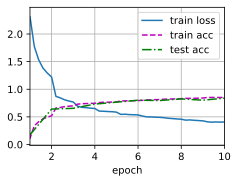

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
lr, num_epochs = 0.9, 10
_, _, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

2. 尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。

    - 调整卷积窗口大小。
    - 调整输出通道的数量。
    - 调整激活函数（如ReLU）。
    - 调整卷积层的数量。
    - 调整全连接层的数量。
    - 调整学习率和其他训练细节（例如，初始化和轮数）。

adjust_conv_windows_size
training on cuda:0
1, train acc 0.77275, test acc 0.773
training on cuda:0
3, train acc 0.8208666666666666, test acc 0.812
training on cuda:0
5, train acc 0.826, test acc 0.8187
training on cuda:0
7, train acc 0.80295, test acc 0.7973
adjust_output_channels
training on cuda:0
(3, 8), train acc 0.8172166666666667, test acc 0.7984
training on cuda:0
(6, 16), train acc 0.8197, test acc 0.8132
training on cuda:0
(12, 32), train acc 0.8244166666666667, test acc 0.8138
adjust_active_func
training on cuda:0
Sigmoid, train acc 0.8224333333333333, test acc 0.8249
training on cuda:0
ReLU, train acc 0.0994, test acc 0.1
training on cuda:0
Tanh, train acc 0.10036666666666667, test acc 0.1
adjust_conv_layer
training on cuda:0
[(1, 6, 5, 2, 1), (6, 16, 5, 1, 1)], train acc 0.8269833333333333, test acc 0.8108
training on cuda:0
[(1, 3, 5, 4, 1), (3, 6, 5, 2, 1), (6, 16, 5, 1, 1)], train acc 0.10028333333333334, test acc 0.1
training on cuda:0
[(1, 6, 5, 4, 1), [6, 16, 5, 2, 1

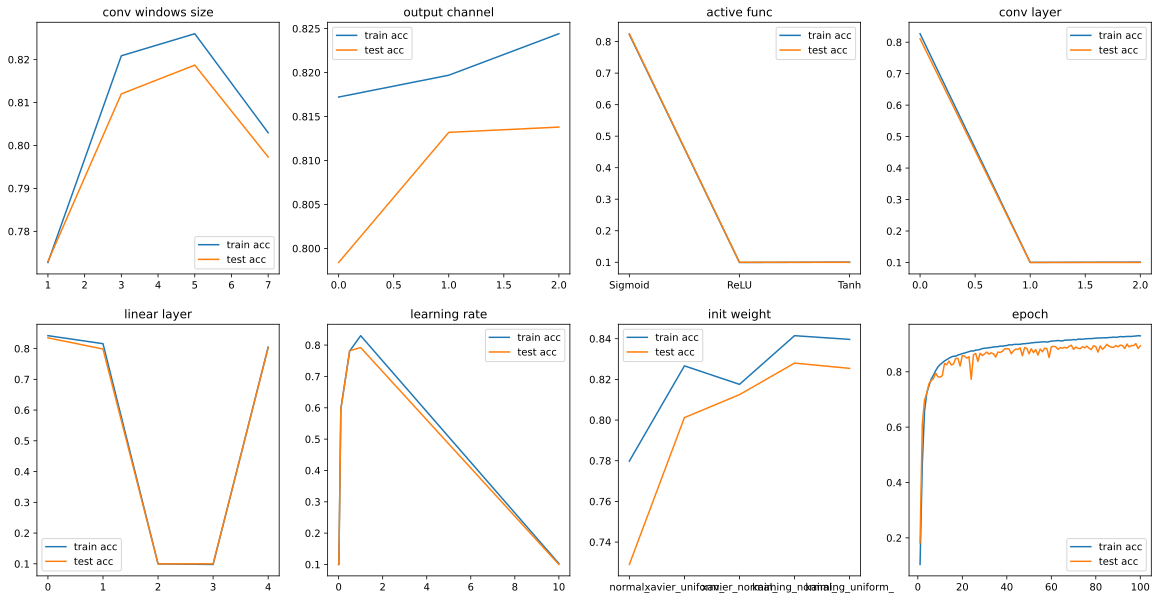

In [5]:
def adjust_conv_windows_size(windows_size, ax):
    ax.set_title("conv windows size")
    def get_net(size):
        s = (32 - 3 * size + 3) // 4
        return nn.Sequential(
                    nn.Conv2d(1, 6, kernel_size=size, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=size), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * s * s, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(),
                    nn.Linear(84, 10))
        return net
    train_acc, test_acc = [], []
    for size in windows_size:
        net = get_net(size)
        acc1, acc2, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, 
                                   lr, d2l.try_gpu(), need_plot=False)
        train_acc.append(acc1)
        test_acc.append(acc2)
        print(f"{size}, train acc {acc1}, test acc {acc2}")
    ax.plot(windows_size, train_acc, label="train acc")
    ax.plot(windows_size, test_acc, label="test acc")

def adjust_output_channels(output_channels, ax):
    ax.set_title("output channel")
    def get_net(output):
        layer1, layer2 = output
        return nn.Sequential(
                    nn.Conv2d(1, layer1, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(layer1, layer2, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(layer2 * 5 * 5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(),
                    nn.Linear(84, 10))
    train_acc, test_acc = [], []
    for output in output_channels:
        net = get_net(output)
        acc1, acc2, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, 
                                   lr, d2l.try_gpu(), need_plot=False)
        print(f"{output}, train acc {acc1}, test acc {acc2}")
        train_acc.append(acc1)
        test_acc.append(acc2)  
    ax.plot(train_acc, label="train acc")
    ax.plot(test_acc, label="test acc")

def adjust_active_func(ax):
    ax.set_title("active func")
    func = [nn.Sigmoid, nn.ReLU, nn.Tanh]
    func_name = [elem.__name__ for elem in func]
    def get_net(f):
        return nn.Sequential(
                    nn.Conv2d(1, 6, kernel_size=5, padding=2), f(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), f(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), f(),
                    nn.Linear(120, 84), f(),
                    nn.Linear(84, 10))
    train_acc, test_acc = [], []
    for f in func:
        net = get_net(f)
        acc1, acc2, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, 
                                   lr, d2l.try_gpu(), need_plot=False)
        train_acc.append(acc1)
        test_acc.append(acc2)  
        print(f"{f.__name__}, train acc {acc1}, test acc {acc2}")
    ax.plot(func_name, train_acc, label="train acc")
    ax.plot(func_name, test_acc, label="test acc")

def adjust_conv_layer(layer_conf, ax):
    ax.set_title("conv layer")
    def get_net(layer):
        size = 28
        net = nn.Sequential()
        for i in layer:
            ci, co, k, p, s = i
            net.append(nn.Conv2d(ci, co, kernel_size=k, padding=p, stride=s))
            size = (size + 2 * p + s - k) // s
            net.append(nn.Sigmoid())
            net.append(nn.AvgPool2d(kernel_size=2, stride=2))
            size = size // 2
        net.append(nn.Flatten())
        net.append(nn.Linear(co * size * size, 120))
        net.append(nn.Sigmoid())
        net.append(nn.Linear(120, 84))
        net.append(nn.Sigmoid())
        net.append(nn.Linear(84, 10))
        return net
    train_acc, test_acc = [], []
    for layer in layer_conf:
        net = get_net(layer)
        acc1, acc2, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, 
                                   lr, d2l.try_gpu(), need_plot=False)
        train_acc.append(acc1)
        test_acc.append(acc2)  
        print(f"{layer}, train acc {acc1}, test acc {acc2}")
    ax.plot(train_acc, label="train acc")
    ax.plot(test_acc, label="test acc")

def adjust_linear_layer(layer_conf, ax):
    ax.set_title("linear layer")
    def get_net(layer):
        net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten())
        prev = 16 * 5 * 5
        for i in layer:
            net.append(nn.Linear(prev, i))
            prev = i
            net.append(nn.Sigmoid())
        net.append(nn.Linear(prev, 10))
        return net
    train_acc, test_acc = [], []
    for layer in layer_conf:
        net = get_net(layer)
        acc1, acc2, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, 
                                   lr, d2l.try_gpu(), need_plot=False)
        train_acc.append(acc1)
        test_acc.append(acc2)  
        print(f"{layer}, train acc {acc1}, test acc {acc2}")
    ax.plot(train_acc, label="train acc")
    ax.plot(test_acc, label="test acc")

def adjust_learning_rate(lr_list, ax):
    ax.set_title("learning rate")
    def get_net():
        return nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, 10))
    train_acc, test_acc = [], []
    for lr_ in lr_list:
        net = get_net()
        acc1, acc2, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, 
                                   lr_, d2l.try_gpu(), need_plot=False)
        train_acc.append(acc1)
        test_acc.append(acc2)  
        print(f"{lr_}, train acc {acc1}, test acc {acc2}")
    ax.plot(lr_list, train_acc, label="train acc")
    ax.plot(lr_list, test_acc, label="test acc")

def adjust_init_way(ax):
    ax.set_title("init weight")
    init_func = [nn.init.normal_, nn.init.xavier_uniform_, nn.init.xavier_normal_, 
                 nn.init.kaiming_normal_, nn.init.kaiming_uniform_]
    func_name = [elem.__name__ for elem in init_func]
    def get_net():
        return nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, 10))
    train_acc, test_acc = [], []
    for init in init_func:
        net = get_net()
        acc1, acc2, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, 
                                   lr, d2l.try_gpu(), need_plot=False, init_func=init)
        train_acc.append(acc1)
        test_acc.append(acc2)  
        print(f"{init.__name__}, train acc {acc1}, test acc {acc2}")
    ax.plot(func_name, train_acc, label="train acc")
    ax.plot(func_name, test_acc, label="test acc")

fig, axes = plt.subplots(figsize=(20, 10), ncols=4, nrows=2)
conv_windows_size = [1, 3, 5, 7]
print("adjust_conv_windows_size")
adjust_conv_windows_size(conv_windows_size, axes[0][0])
output_channels_pair = [(3, 8), (6, 16), (12, 32)]
print("adjust_output_channels")
adjust_output_channels(output_channels_pair, axes[0][1])
print("adjust_active_func")
adjust_active_func(axes[0][2])
conv_layer_conf = [
    [(1, 6, 5, 2, 1),(6, 16, 5, 1, 1)], 
    [(1, 3, 5, 4, 1), (3, 6, 5, 2, 1), (6, 16, 5, 1, 1)],
    [(1, 6, 5, 4, 1), [6, 16, 5, 2, 1], (16, 28, 5, 1, 1)]
]
print("adjust_conv_layer")
adjust_conv_layer(conv_layer_conf, axes[0][3])
linear_layer_conf = [
    [], [120, 84], [256, 128, 64], [512, 256, 128, 32], [512, 64]
]
print("adjust_linear_layer")
adjust_linear_layer(linear_layer_conf, axes[1][0])
learning_rate_list = [1e-4, 0.01, 0.1, 0.5, 1, 10]
print("adjust_learning_rate")
adjust_learning_rate(learning_rate_list, axes[1][1])
print("adjust_init_way")
adjust_init_way(axes[1][2])
print("adjust epoch")
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
_, _, train_acc_list, test_acc_list = d2l.train_ch6(net, train_iter, test_iter, 100, lr, d2l.try_gpu(),
                                                    need_plot=False)
axes[1][3].set_title("epoch")
axes[1][3].plot(list(range(1, 101)), train_acc_list, label="train acc")
axes[1][3].plot(list(range(1, 101)), test_acc_list, label="test acc")
for i in range(2):
    for j in range(4):
        axes[i][j].legend()
plt.show()

4. 在MNIST数据集上尝试以上改进的网络。

In [6]:
train_data = datasets.MNIST(root="../data", train=True, download=True, 
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root="../data", train=True, download=False, 
                            transform=transforms.ToTensor())
len(train_data), len(test_data)

(60000, 60000)

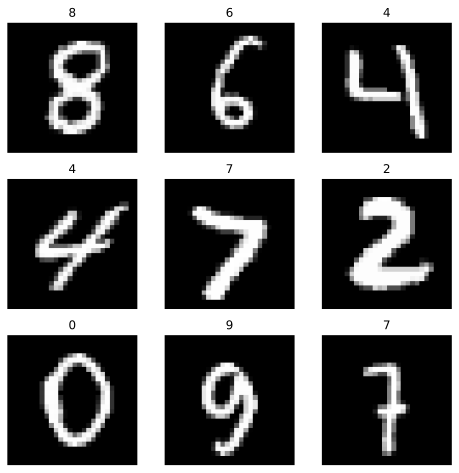

In [20]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

loss 0.004, train acc 0.999, test acc 0.999
29238.2 examples/sec on cuda:0


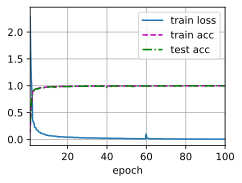

In [8]:
net = nn.Sequential(
    nn.Conv2d(1, 12, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(12, 32, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 5 * 5, 512), nn.Sigmoid(),
    nn.Linear(512, 64), nn.Sigmoid(),
    nn.Linear(64, 10))
lr = 1
init_func = nn.init.kaiming_uniform_
num_epochs = 100
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True,
                                        num_workers=d2l.get_dataloader_workers())
test_iter = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False,
                                        num_workers=d2l.get_dataloader_workers())
_, _, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(), init_func=init_func)

4. 显示不同输入（例如毛衣和外套）时，LeNet第一层和第二层的激活值。

loss 0.464, train acc 0.826, test acc 0.789
34128.4 examples/sec on cuda:0


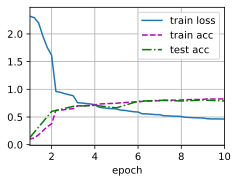

In [9]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.9, 10
_, _, _, _ = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [86]:
def get_distinct_samples(n):
    test_data: datasets.FashionMNIST = test_iter.dataset
    assert n <= len(test_data.classes)
    X = []
    included_label = []
    while len(X) < n:
        sample_idx = torch.randint(len(test_data), size=(1,)).item()
        img, label = test_data[sample_idx]
        if label in included_label:
            continue
        X.append((img, label))
        included_label.append(label)
    return X

def plot_conv_layer(X):
    figure = plt.figure(layout="constrained", figsize=(12, 4))
    img, label = X
    subfigures = figure.subfigures(1, 3, wspace=0.1, width_ratios=[0.1, 0.3, 0.6])
    subfigures[0].set_facecolor('aqua')
    subfigures[1].set_facecolor('gold')
    subfigures[2].set_facecolor('silver')
    ax = subfigures[0].add_subplot(4, 1, 2)
    ax.set_title(test_iter.dataset.classes[label])
    ax.axis("off")
    ax.imshow(img.squeeze(), cmap="gray")
    img_cuda = img.to(d2l.try_gpu())
    X = net[0](img_cuda) # conv 1
    X = net[1](X) # sigmoid 1
    assert X.shape[0] == 6
    for i in range(3):
        idx = i * 2 + 1
        for j in range(2):
            subfigures[1].add_subplot(4, 2, idx)
            plt.axis("off")
            plt.imshow(X[i*2+j].cpu().detach().numpy().squeeze(), cmap="gray")
            idx += 1
    X = net[2](X) # AvgPool2D 1
    X = net[3](X) # conv 2
    X = net[4](X) # sigmoid 2
    assert X.shape[0] == 16
    for i in range(4):
        idx = i * 4 + 1
        for j in range(4):
            subfigures[2].add_subplot(4, 4, idx)
            plt.axis("off")
            plt.imshow(X[i*4+j].cpu().detach().numpy().squeeze(), cmap="gray")
            idx += 1
    plt.show()

X = get_distinct_samples(2)

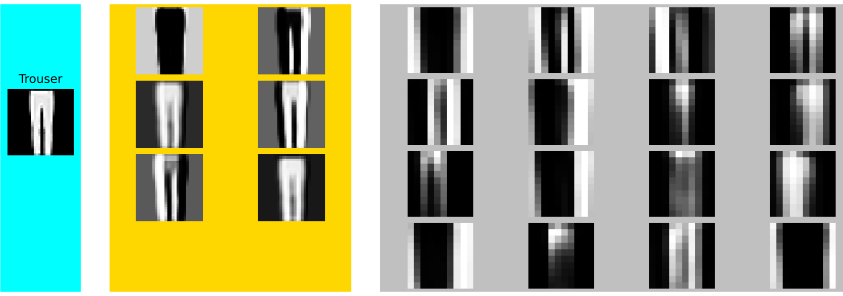

In [87]:
plot_conv_layer(X[0])

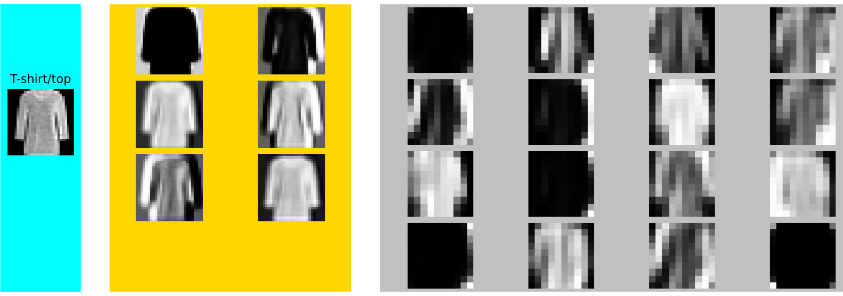

In [88]:
plot_conv_layer(X[1])